In [1]:
import sys
import numpy as np
import xarray as xr
xr.set_options(display_style='html')
import intake

from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.postprocessing import match_metrics
import dask

from timeit import default_timer as timer
import cartopy.crs as ccrs
import shapely
import warnings
# from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings("ignore", ccmioategory=ShapelyDeprecationWarning) 
import matplotlib.pyplot as plt
%matplotlib inline

import os
DIR_DATA = os.path.join("/nethome", "terps020", "cmip6", "data")
DIR_DATA

'/nethome/terps020/cmip6/data'

In [2]:
# catalog url
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)

In [3]:
cat

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [8]:
unique = cat.search(activity_id="CMIP", experiment_id="1pctCO2", variable_id="tas", grid_label="gr").unique()
print("Database contents for CMIP with 1pctCO2 with tas and grid_label gr")
print(f"{len(unique_activities:=sorted(unique['activity_id']))} unique MIPs: {unique_activities}\n")
print(f"{len(unique_models:=sorted(unique['source_id']))} unique models: {unique_models}\n")
print(f"{len(unique_experiments:=sorted(unique['experiment_id']))} unique experiments: {unique_experiments}\n")

unique = cat.search(activity_id="ScenarioMIP").unique()
print("------------------------------------------")
print("Database contents for ScenarioMIP")
print(f"{len(unique_activities:=sorted(unique['activity_id']))} unique MIPs: {unique_activities}\n")
print(f"{len(unique_models:=sorted(unique['source_id']))} unique models: {unique_models}\n")
print(f"{len(unique_experiments:=sorted(unique['experiment_id']))} unique experiments: {unique_experiments}\n")

# print(f"{len(unique_variables:=sorted(unique['variable_id']))} unique variables: {unique_variables}\n")

Database contents for CMIP with 1pctCO2 with tas and grid_label gr
1 unique MIPs: ['CMIP']

13 unique models: ['CIESM', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'KACE-1-0-G']

1 unique experiments: ['1pctCO2']

------------------------------------------
Database contents for ScenarioMIP
1 unique MIPs: ['ScenarioMIP']

51 unique models: ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'E3SM-1-1', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM5A2-IN

In [13]:
query = dict(
    experiment_id="1pctCO2", variable_id='tas', grid_label=["gr"],
    source_id=["IPSL-CM6A-LR"], member_id="r1i1p1f1", table_id="Amon"
)

cat_subset = cat.search(**query)
cat_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,1pctCO2,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1pctCO...,NaN,20180727


In [14]:
query_piControl = dict(
    experiment_id="piControl", variable_id='tas', grid_label=["gr"],
    source_id=["IPSL-CM6A-LR"], member_id="r1i1p1f1"
)

cat_subset_piControl = cat.search(**query_piControl)
cat_subset_piControl.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20200326


In [ ]:
kwargs = {
    "xarray_open_kwargs":{
        "consolidated": True,
        "decode_times": True,
        "use_cftime": True
    },
    "aggregate": False,
    "progressbar": True,
    "skip_on_error": False,
    "preprocess": combined_preprocessing
}
with dask.config.set(**{"array.slicing.split_large_chunks": True}):
    dset_dict = cat_subset.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [16]:
kwargs = {
    "xarray_open_kwargs":{
        "consolidated": True,
        "decode_times": True,
        "use_cftime": True
    },
    "aggregate": False,
    "progressbar": True,
    "skip_on_error": False,
    "preprocess": combined_preprocessing
}
with dask.config.set(**{"array.slicing.split_large_chunks": True}):
    dset_dict_piControl = cat_subset_piControl.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [17]:
print(list(dset_dict.keys()))
print(list(dset_dict_piControl.keys()))


['CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1.Amon.tas.gr.gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1pctCO2/r1i1p1f1/Amon/tas/gr/v20180727/.nan.20180727']
['CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i1p1f1.Amon.tas.gr.gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/tas/gr/v20200326/.nan.20200326']


In [26]:
query_areacella = dict(
    experiment_id="1pctCO2", variable_id="areacella", grid_label=["gr"],
    source_id=["IPSL-CM6A-LR"], member_id="r1i1p1f1"
)
cat_areacella = cat.search(**query_areacella)
cat_areacella.df


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,1pctCO2,r1i1p1f1,fx,areacella,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1pctCO...,NaN,20180727


In [27]:
query_areacella_piControl = dict(
    experiment_id="piControl", variable_id="areacella", grid_label=["gr"],
    source_id=["IPSL-CM6A-LR"], member_id="r1i1p1f1"
)
cat_areacella_piControl = cat.search(**query_areacella_piControl)
cat_areacella_piControl.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i1p1f1,fx,areacella,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20181123


In [29]:
with dask.config.set(**{"array.slicing.split_large_chunks": True}):
    ddict_areacella = cat_areacella.to_dataset_dict(**kwargs)
print(list(ddict_areacella.keys()))

with dask.config.set(**{"array.slicing.split_large_chunks": True}):
    ddict_areacella_piControl = cat_areacella_piControl.to_dataset_dict(**kwargs)
print(list(ddict_areacella_piControl.keys()))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1.fx.areacella.gr.gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1pctCO2/r1i1p1f1/fx/areacella/gr/v20180727/.nan.20180727']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i1p1f1.fx.areacella.gr.gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/fx/areacella/gr/v20181123/.nan.20181123']


In [30]:
ddict_matched = match_metrics(dset_dict, ddict_areacella, ["areacella"])
ddict_matched_piControl = match_metrics(dset_dict_piControl, ddict_areacella_piControl, ["areacella"])
print(list(ddict_matched.keys())[0])
print(list(ddict_matched_piControl.keys())[0])

CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1.Amon.tas.gr.gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1pctCO2/r1i1p1f1/Amon/tas/gr/v20180727/.nan.20180727
CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i1p1f1.Amon.tas.gr.gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/tas/gr/v20200326/.nan.20200326


In [31]:
ds = ddict_matched[list(ddict_matched.keys())[0]]
ds_piControl = ddict_matched_piControl[list(ddict_matched_piControl.keys())[0]]
ds_piControl

<xarray.Dataset>
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 14400, y: 143,
                     x: 144)
Coordinates:
  * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time            (time) object 1850-01-16 12:00:00 ... 3049-12-16 12:00:00
    lon             (x, y) float32 360.0 360.0 360.0 360.0 ... 357.5 357.5 357.5
    lat             (x, y) float32 -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    areacella       (member_id, dcpp_init_year, y, x) float32 dask.array<chunksize=(1, 1, 143, 144), meta=np.ndarray>
Data variables:
    height          float64 2.0
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 2074, 143, 144), meta=np.ndarray>
Attributes: (12/67)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            piControl
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR...
    intake_esm_attrs:version:         20200326
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i1p1...

In [32]:
fname = os.path.join(list(ddict_matched.keys())[0] + ".nc")
fname = ".".join(fname.split(".")[:8]) + ".nc"
print(fname)

fname_piControl = os.path.join(list(ddict_matched_piControl.keys())[0] + ".nc")
fname_piControl = ".".join(fname_piControl.split(".")[:8]) + ".nc"
print(fname_piControl)

CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1.Amon.tas.gr.nc
CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i1p1f1.Amon.tas.gr.nc


In [33]:
ds.to_netcdf(os.path.join(DIR_DATA, fname))
ds_piControl.to_netcdf(os.path.join(DIR_DATA, fname_piControl))



In [49]:
ds

<xarray.Dataset>
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1800, y: 143,
                     x: 144, bnds: 2)
Coordinates:
  * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time            (time) object 1850-01-16 12:00:00 ... 1999-12-16 12:00:00
    time_bounds     (time, bnds) object dask.array<chunksize=(1800, 2), meta=np.ndarray>
    lon             (x, y) float32 360.0 360.0 360.0 360.0 ... 357.5 357.5 357.5
    lat             (x, y) float32 -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    areacella       (member_id, dcpp_init_year, y, x) float32 dask.array<chunksize=(1, 1, 143, 144), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    height          float64 2.0
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 900, 143, 144), meta=np.ndarray>
Attributes: (12/67)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            1pctCO2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR...
    intake_esm_attrs:version:         20180727
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.1pctCO2.r1i1p1f1...

In [34]:
ds_disk = xr.open_dataset(os.path.join(DIR_DATA, fname_piControl))

/nethome/terps020/.conda/envs/cmip6-download/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nethome/terps020/.conda/envs/cmip6-download/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [35]:
ds_disk

<xarray.Dataset>
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 14400, y: 143,
                     x: 144)
Coordinates:
    height          float64 ...
  * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time            (time) object 1850-01-16 12:00:00 ... 3049-12-16 12:00:00
    lon             (x, y) float32 ...
    lat             (x, y) float32 ...
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    areacella       (member_id, dcpp_init_year, y, x) float32 ...
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 ...
Attributes: (12/67)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            piControl
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR...
    intake_esm_attrs:version:         20200326
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i1p1...

Test data

In [39]:
tas = ds_disk.tas.squeeze().load()
tas

<xarray.DataArray 'tas' (time: 14400, y: 143, x: 144)>
array([[[243.13188, 243.13188, 243.13188, ..., 243.13188, 243.13188,
         243.13188],
        [244.77808, 244.7232 , 244.66112, ..., 244.96474, 244.8931 ,
         244.86455],
        [245.24695, 245.10483, 245.04428, ..., 245.50224, 245.44318,
         245.32355],
        ...,
        [238.46233, 238.54768, 238.44733, ..., 238.68042, 238.539  ,
         238.64365],
        [237.96092, 237.90472, 237.90225, ..., 237.92232, 237.95737,
         237.94087],
        [236.82423, 236.82423, 236.82423, ..., 236.82423, 236.82423,
         236.82423]],

       [[229.22513, 229.22513, 229.22513, ..., 229.22513, 229.22513,
         229.22513],
        [231.79976, 231.72108, 231.63832, ..., 232.00098, 231.92851,
         231.88559],
        [232.95505, 232.81328, 232.65775, ..., 233.29752, 233.20554,
         233.1009 ],
...
        [247.51396, 247.60612, 247.72919, ..., 247.13762, 247.35622,
         247.44011],
        [247.73418, 247.74417, 247.81287, ..., 247.59421, 247.62402,
         247.6299 ],
        [246.76628, 246.76628, 246.76628, ..., 246.76628, 246.76628,
         246.76628]],

       [[245.07777, 245.07777, 245.07777, ..., 245.07777, 245.07777,
         245.07777],
        [247.03831, 246.94771, 246.89381, ..., 247.2044 , 247.14696,
         247.1039 ],
        [247.81506, 247.69115, 247.5448 , ..., 248.16817, 248.04352,
         247.94994],
        ...,
        [246.84135, 246.9522 , 247.0272 , ..., 246.75417, 246.80957,
         246.83014],
        [247.10585, 247.13835, 247.20181, ..., 247.02129, 247.03845,
         247.03896],
        [244.16267, 244.16267, 244.16267, ..., 244.16267, 244.16267,
         244.16267]]], dtype=float32)
Coordinates:
    height          float64 2.0
  * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time            (time) object 1850-01-16 12:00:00 ... 3049-12-16 12:00:00
    lon             (x, y) float32 360.0 360.0 360.0 360.0 ... 357.5 357.5 357.5
    lat             (x, y) float32 -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
    areacella       (y, x) float32 1.084e+08 1.084e+08 ... 1.084e+08 1.084e+08
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         Near-Surface Air Temperature
    history:             none
    interval_operation:  900 s
    interval_write:      1 month
    long_name:           Near-Surface Air Temperature
    online_operation:    average
    standard_name:       air_temperature
    units:               K

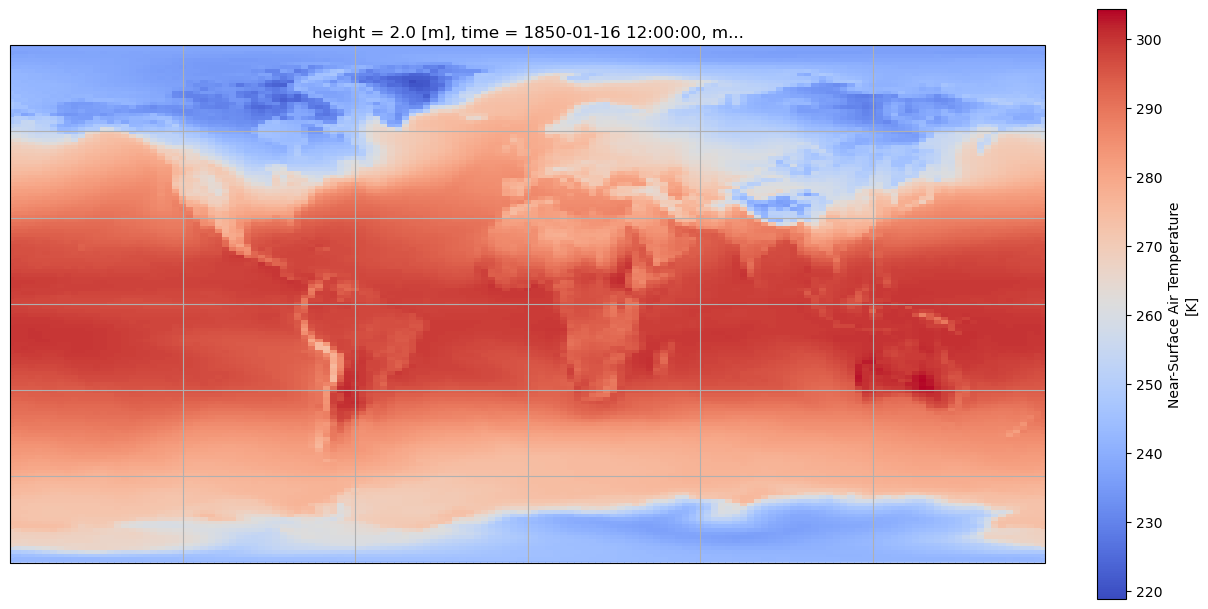

In [47]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
ax.gridlines()
tas.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm'
);